In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from skbio.stats.composition import clr
from sklearn.preprocessing import normalize
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore", message="FutureWarning")

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/')
from libraries.survival import *
from libraries.clinical import load_clinical, load_genetics
from libraries.data_processing import *
from libraries.forest_plots import *

In [70]:
# Feature selection
leiden_clusters, malignant_clusters, stromal_clusters = load_topography()
all_abnormal = np.append(malignant_clusters, stromal_clusters)
groupby     = f'leiden_2.5'
h5_complete_path   = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/hdf5_LATTICeA_5x_he_complete_surv_sex_filtered.h5'
h5_additional_path = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/hdf5_TCGA_LUAD_5x_he_train_filtered_overall_survival.h5'
meta_folder        = 'rapids_2p5m'
matching_field     = 'samples'
event_ind_field    = 'os_event_ind'
event_data_field   = 'os_event_data'

main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')


# Get clinical data
clinpath, survival, patterns_samples = load_clinical()
survival = survival.merge(patterns_samples[['samples', 'iaslc_grade']], on='samples')
survival

/mnt/cephfs/sharedscratch/users/krakovic/HPL-LATTICeA/libraries/clinical.py:7: DtypeWarning: Columns (2,10,30,37,38,52,67,84,85,110,118,134,135,136,137,138,148,149,150,217,219,221,223,224,225,226,236,242,243,244,245,248,249,250,251,252,253,254,255,256,257,261,262,263,264,265,266,267,268,269,270,271,280,282,283,285,288,289,294,295,298,299,310,311,312,313,314,315,316,317,340,374,440,441,442,443,446,447,448,449,450,451,452,453,454,455,459,460,461,462,463,464,465,466,467,468,469,481,487,508,509,510,511,512,513,514,515,538,572,638,639,640,641,644,645,646,647,648,649,650,651,652,653,657,658,659,660,661,662,663,664,665,666,667,679,685,706,707,708,709,710,711,712,713,736,770,834,835,836,839,863,887) have mixed types. Specify dtype option on import or set low_memory=False.
  clinpath = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/datasets/LATTICeA/latticea_master_clinicopathological.csv')


,index,sample_ID,Originator,Checked,Pathology Number,Case Number,male,Complete?,Receipt Delay (Days),age,...,Invasion.10,Donor Block Number.11,Core Row.11,Core Column.11,Invasion.11,Complete?.6,samples,stage_num,PDL_positive,iaslc_grade
0,11,13,ms831,crs20,PR022438N/10,2,0,Incomplete,0,76,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0002,1,NaN,3
1,253,14,ms831,crs20,PR025028M/10,3,1,Incomplete,1,77,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0003,1,0.0,2
2,14,18,ms831,crs20,PR026550L/10,4,0,Incomplete,1,61,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0004,3,0.0,3
3,133,27,ms831,crs20,PR029768B/10,5,0,Incomplete,0,64,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0005,1,0.0,1
4,34,40,crs20,ms831,PR030965Y/10,6,0,Incomplete,1,81,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_0006,2,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,1020,1054,ms831,NaN,PR051543M/15,1108,0,Incomplete,0,61,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1108,1,0.0,3
799,1021,1055,ms831,NaN,PR051580N/15,1109,1,Incomplete,4,83,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1109,1,0.0,3
800,1022,1056,ms831,NaN,PR051863R/15,1110,0,Incomplete,0,71,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1110,2,1.0,3
801,1023,1057,ms831,NaN,PR052068K/15,1112,1,Incomplete,0,65,...,NaN,NaN,NaN,NaN,NaN,Incomplete,ACA_1112,1,0.0,3


In [71]:
clinpath_mo = clinpath.rename(columns={'Time to Survival Status (Days)':'os_event_data',
                                        'Survival Status':'os_event_ind',
                                        'Age at Surgery':'age',
                                        'Sex':'male',
                                        'Overall Stage (8th TNM Edition)':'stage',
                                        })
clinpath_mo = clinpath_mo.replace({'Dead':1, 'Alive': 0})
clinpath_mo = clinpath_mo.replace({'IA1': 'I', 'IA2':'I', 'IA3':'I', 'IB':'I', 
                                'IIA': 'II', 'IIB':'II',
                                'IIIA':'III', 'IIIB':'III', 'IIIC':'III', 
                                'IVA':'IV'})

clinpath_mo['stage_num'] = clinpath_mo['stage'].map({'I':1, 'II':2, 'III':3, 'IV':3})
clinpath_mo['stage_num'] = pd.Categorical(clinpath_mo['stage_num'], categories=[1, 2, 3], ordered=True)

clinpath_mo = clinpath_mo.replace({'MALE': 1, 'FEMALE': 0})
clinpath_mo['os_event_data'] = clinpath_mo['os_event_data'] / 365 * 12

patterns_samples['iaslc_grade'] = patterns_samples['iaslc_grade_'].apply(lambda x: 1 if x == 'G3' else 0)


In [72]:
genetics = load_genetics()

In [73]:
complete_df, additional_df, leiden_clusters = read_csvs_forcefold(adatas_path=adatas_path, groupby=groupby, h5_complete_path=h5_complete_path, h5_additional_path=h5_additional_path, force_fold=2)
sample_rep_df = generate_frequency_vector(complete_df=complete_df, matching_field='samples', groupby=groupby, leiden_clusters=sorted(list(malignant_clusters)+[10,16]), transform=False)


In [74]:
sample_rep_df.columns = [int(c) for c in sample_rep_df.columns[:-1]] + ['samples']
sample_rep_df

,0,5,10,11,13,16,17,21,27,28,...,48,50,52,54,61,64,67,68,69,samples
0,0.003670,0.000459,0.019725,0.050459,0.002294,0.177982,0.015138,0.000459,0.000000,0.059174,...,0.037156,0.104587,0.001376,0.067431,0.008716,0.004128,0.150000,0.016055,0.124771,ACA_0193
1,0.000000,0.000774,0.051613,0.021419,0.000516,0.009548,0.000000,0.000000,0.000000,0.027871,...,0.024774,0.001548,0.488000,0.000000,0.036129,0.003613,0.006968,0.000258,0.017290,ACA_0324
2,0.287338,0.003247,0.006494,0.000000,0.016234,0.095779,0.006494,0.000000,0.011364,0.000000,...,0.000000,0.004870,0.001623,0.000000,0.024351,0.021104,0.047078,0.047078,0.081169,ACA_0476
3,0.000000,0.014812,0.110876,0.000000,0.022006,0.031739,0.276344,0.008887,0.003386,0.044858,...,0.089716,0.039357,0.000000,0.001270,0.120186,0.081253,0.000000,0.000423,0.006348,ACA_0837
4,0.036900,0.000000,0.221402,0.000000,0.003690,0.420664,0.029520,0.000000,0.000000,0.059041,...,0.000000,0.003690,0.003690,0.003690,0.073801,0.000000,0.088561,0.000000,0.025830,ACA_0574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,0.000987,0.000658,0.015800,0.004279,0.001646,0.010204,0.002633,0.000987,0.007242,0.000329,...,0.027321,0.019421,0.564187,0.000329,0.045095,0.039171,0.000000,0.002304,0.048716,ACA_0779
1003,0.005226,0.000000,0.088850,0.000000,0.111498,0.121951,0.010453,0.000000,0.019164,0.071429,...,0.033101,0.024390,0.000000,0.000000,0.113240,0.029617,0.001742,0.000000,0.020906,ACA_0626
1004,0.000740,0.001036,0.000000,0.148208,0.001036,0.000296,0.001184,0.001777,0.001629,0.000000,...,0.000000,0.019840,0.024282,0.371039,0.000000,0.001629,0.004886,0.004442,0.002221,ACA_0656
1005,0.029304,0.007326,0.000000,0.000000,0.032967,0.029304,0.065934,0.003663,0.000000,0.025641,...,0.032967,0.234432,0.000000,0.010989,0.058608,0.003663,0.087912,0.003663,0.032967,ACA_0406


In [75]:
non_mucinous_samples = clinpath[~clinpath['2015 WHO Classification'].isin(['Invasive mucinous adenocarcinoma (IMA)', 'Colloid adenocarcinoma', 'Enteric adenocarcinoma', 'Not given', 'Adenocarcinoma in situ (AIS)'])]['samples']
sample_rep_df_with_mucinous = sample_rep_df.copy(deep=True)
sample_rep_df = sample_rep_df[sample_rep_df['samples'].isin(non_mucinous_samples)]

In [76]:
sample_rep_df

,0,5,10,11,13,16,17,21,27,28,...,48,50,52,54,61,64,67,68,69,samples
0,0.003670,0.000459,0.019725,0.050459,0.002294,0.177982,0.015138,0.000459,0.000000,0.059174,...,0.037156,0.104587,0.001376,0.067431,0.008716,0.004128,0.150000,0.016055,0.124771,ACA_0193
2,0.287338,0.003247,0.006494,0.000000,0.016234,0.095779,0.006494,0.000000,0.011364,0.000000,...,0.000000,0.004870,0.001623,0.000000,0.024351,0.021104,0.047078,0.047078,0.081169,ACA_0476
3,0.000000,0.014812,0.110876,0.000000,0.022006,0.031739,0.276344,0.008887,0.003386,0.044858,...,0.089716,0.039357,0.000000,0.001270,0.120186,0.081253,0.000000,0.000423,0.006348,ACA_0837
4,0.036900,0.000000,0.221402,0.000000,0.003690,0.420664,0.029520,0.000000,0.000000,0.059041,...,0.000000,0.003690,0.003690,0.003690,0.073801,0.000000,0.088561,0.000000,0.025830,ACA_0574
5,0.000764,0.015533,0.003820,0.270435,0.016552,0.007639,0.002037,0.018844,0.015788,0.001019,...,0.028011,0.114082,0.028266,0.091418,0.006621,0.092692,0.001273,0.042271,0.014260,ACA_0484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.108108,0.015444,0.029923,0.000000,0.045367,0.084942,0.051158,0.006757,0.016409,0.030888,...,0.022201,0.069498,0.000000,0.002896,0.051158,0.133205,0.070463,0.047297,0.036680,ACA_0412
1003,0.005226,0.000000,0.088850,0.000000,0.111498,0.121951,0.010453,0.000000,0.019164,0.071429,...,0.033101,0.024390,0.000000,0.000000,0.113240,0.029617,0.001742,0.000000,0.020906,ACA_0626
1004,0.000740,0.001036,0.000000,0.148208,0.001036,0.000296,0.001184,0.001777,0.001629,0.000000,...,0.000000,0.019840,0.024282,0.371039,0.000000,0.001629,0.004886,0.004442,0.002221,ACA_0656
1005,0.029304,0.007326,0.000000,0.000000,0.032967,0.029304,0.065934,0.003663,0.000000,0.025641,...,0.032967,0.234432,0.000000,0.010989,0.058608,0.003663,0.087912,0.003663,0.032967,ACA_0406


In [77]:
from libraries.supercluster_dictionary import assign_supercluster

sample_rep_df_melt = pd.melt(sample_rep_df, id_vars=['samples'], value_vars=malignant_clusters, var_name='cluster', value_name='frequency')
sample_rep_df_melt['cluster'] = sample_rep_df_melt['cluster'].apply(lambda x: f'HPC {x}')
sample_rep_df_melt['supercluster'] = sample_rep_df_melt['cluster'].apply(lambda x: assign_supercluster(x)) 
sample_rep_df_melt = sample_rep_df_melt[sample_rep_df_melt['supercluster'] != 'Unknown']
samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('sum')['frequency'].reset_index()
samples_by_supercluster = samples_by_supercluster.pivot(columns=['supercluster'], index='samples', values='frequency')
samples_by_supercluster

/tmp/ipykernel_2165419/2899483114.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('sum')['frequency'].reset_index()


supercluster,"Cold, cohesive","Cold, discohesive","Hot, cohesive","Hot, discohesive"
samples,,,,
ACA_0002,0.148699,0.362454,0.247212,0.161710
ACA_0003,0.321199,0.114918,0.137045,0.179872
ACA_0004,0.381119,0.066434,0.115385,0.129371
ACA_0005,0.017937,0.058296,0.650224,0.192825
ACA_0006,0.306132,0.141509,0.166981,0.260377
...,...,...,...,...
ACA_1108,0.053922,0.093137,0.573529,0.220588
ACA_1109,0.212647,0.242941,0.093235,0.391471
ACA_1110,0.080092,0.124714,0.225400,0.440503


### Nodal status

In [78]:
from scipy import stats

def enrichment_to_dataframe(features, log_fold_change, p_values, adj_p_values=None, p_sig_mask=None):
    df = pd.DataFrame()
    df['hpc'] = features
    df['log_fold_change'] = log_fold_change
    df['p_val'] = p_values
    df['p_adj'] = adj_p_values
    df['alpha_mask'] = p_sig_mask
    return df

def enrichment_analysis(df, feature_cols, meta_field, plot_sig_only, alpha=0.01, ax=None):
    if np.unique(df[meta_field]).shape[0] > 2:
        print(f"Covariate {meta_field} must be binary")
        raise ValueError
    
    covariate_mask = df[meta_field] == 1
    positive = df[covariate_mask][feature_cols].values
    negative = df[~covariate_mask][feature_cols].values

    mean_positive = np.mean(positive, axis=0)
    mean_negative = np.mean(negative, axis=0)
    log_fold_change = np.log2(mean_positive / mean_negative)

    statistic, p_vals = stats.mannwhitneyu(positive, negative)
    # sorted_p = p_vals[sorted_indices]
    p_vals_adj = stats.false_discovery_control(p_vals, method='bh')
    p_sig_mask_adj = p_vals_adj < alpha

    features_int = [int(x) for x in feature_cols]

    results_frame = enrichment_to_dataframe(features=np.array(features_int), log_fold_change=log_fold_change, p_values=p_vals, adj_p_values=p_vals_adj, p_sig_mask=p_sig_mask_adj)
    plot_enrichment(results_frame=results_frame, meta_field=meta_field, alpha=alpha, plot_sig_only=plot_sig_only, ax=ax)
    
    return results_frame
    # plt.gca().invert_yaxis()

def plot_enrichment(results_frame, meta_field, alpha, plot_sig_only, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    results_frame = results_frame.sort_values(by='log_fold_change', ascending=False)
    results_frame = results_frame[~results_frame['log_fold_change'].isna()]
    if plot_sig_only:
        results_frame = results_frame[results_frame['alpha_mask_unadj'] == True]
    x = np.arange(len(results_frame['log_fold_change']))
    ax.barh(x, results_frame['log_fold_change'].values)
    ax.set_ylabel('HPC')
    ax.set_xlabel('Log Fold Change')
    ax.set_yticks(x, results_frame['hpc'].values)
    ax.set_title(f'{meta_field}')
    if not plot_sig_only:
        for i in x:
            if results_frame['p_adj'].values[i] < alpha:
                ax.get_children()[i].set_color('#4E79A7')
                # ax.get_children()[i].set_color('#E15759') # red
            else:
                ax.get_children()[i].set_color('lightgrey')
                # ax.get_children()[i].set_color('#4E79A7') # blue


In [79]:
nodal_df = clinpath_mo[clinpath_mo['Nodal status'].isin(['N0', 'N1', 'N2'])][['samples', 'os_event_ind', 'os_event_data', 'Nodal status']]
nodal_df

,samples,os_event_ind,os_event_data,Nodal status
1,ACA_0002,0,18.739726,N0
2,ACA_0003,1,57.304110,N0
3,ACA_0004,1,35.178082,N0
4,ACA_0005,0,61.315068,N0
5,ACA_0006,1,0.558904,N0
...,...,...,...,...
1020,ACA_1108,0,31.791781,N0
1021,ACA_1109,1,20.712329,N0
1022,ACA_1110,1,21.994521,N1
1023,ACA_1112,1,24.427397,N0


In [80]:
joint_nodal_df = sample_rep_df.merge(nodal_df, on='samples', how='inner')
joint_nodal_df['n_stage'] = joint_nodal_df['Nodal status'].apply(lambda x: 0 if x == 'N0' else 1)
joint_nodal_df

,0,5,10,11,13,16,17,21,27,28,...,61,64,67,68,69,samples,os_event_ind,os_event_data,Nodal status,n_stage
0,0.003670,0.000459,0.019725,0.050459,0.002294,0.177982,0.015138,0.000459,0.000000,0.059174,...,0.008716,0.004128,0.150000,0.016055,0.124771,ACA_0193,0,71.539726,N0,0
1,0.287338,0.003247,0.006494,0.000000,0.016234,0.095779,0.006494,0.000000,0.011364,0.000000,...,0.024351,0.021104,0.047078,0.047078,0.081169,ACA_0476,0,36.164384,N0,0
2,0.000000,0.014812,0.110876,0.000000,0.022006,0.031739,0.276344,0.008887,0.003386,0.044858,...,0.120186,0.081253,0.000000,0.000423,0.006348,ACA_0837,1,74.991781,N2,1
3,0.036900,0.000000,0.221402,0.000000,0.003690,0.420664,0.029520,0.000000,0.000000,0.059041,...,0.073801,0.000000,0.088561,0.000000,0.025830,ACA_0574,0,49.578082,N0,0
4,0.000764,0.015533,0.003820,0.270435,0.016552,0.007639,0.002037,0.018844,0.015788,0.001019,...,0.006621,0.092692,0.001273,0.042271,0.014260,ACA_0484,1,42.410959,N0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,0.108108,0.015444,0.029923,0.000000,0.045367,0.084942,0.051158,0.006757,0.016409,0.030888,...,0.051158,0.133205,0.070463,0.047297,0.036680,ACA_0412,0,35.309589,N0,0
813,0.005226,0.000000,0.088850,0.000000,0.111498,0.121951,0.010453,0.000000,0.019164,0.071429,...,0.113240,0.029617,0.001742,0.000000,0.020906,ACA_0626,1,78.147945,N0,0
814,0.000740,0.001036,0.000000,0.148208,0.001036,0.000296,0.001184,0.001777,0.001629,0.000000,...,0.000000,0.001629,0.004886,0.004442,0.002221,ACA_0656,1,11.112329,N0,0
815,0.029304,0.007326,0.000000,0.000000,0.032967,0.029304,0.065934,0.003663,0.000000,0.025641,...,0.058608,0.003663,0.087912,0.003663,0.032967,ACA_0406,0,34.454795,N0,0


In [81]:
joint_nodal_df['n_stage'].value_counts()

0    502
1    315
Name: n_stage, dtype: int64

In [82]:
from matplotlib.patches import Patch

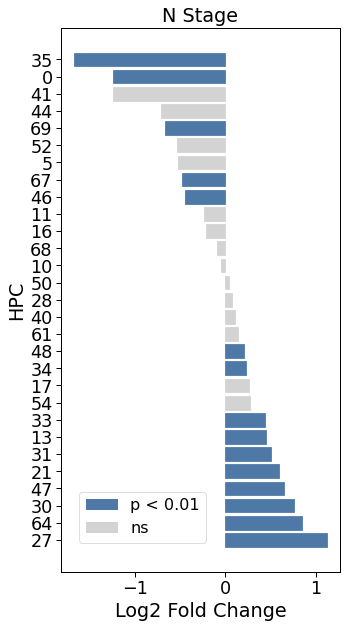

In [83]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(5,10))

nodal_results = enrichment_analysis(df=joint_nodal_df, feature_cols=sorted(list(malignant_clusters)+[10,16]), meta_field='n_stage', plot_sig_only=False, ax=ax)
ax.set_title('N Stage')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.55,0.1), fontsize=16)

### PL stage

In [84]:
pleural_df = clinpath_mo[clinpath_mo['Pleural Involvement'].isin(['PL0', 'PL1', 'PL2', 'PL3'])][['samples', 'os_event_ind', 'os_event_data', 'Pleural Involvement']]
pleural_df

,samples,os_event_ind,os_event_data,Pleural Involvement
0,ACA_0001,1,83.079452,PL1
1,ACA_0002,0,18.739726,PL0
2,ACA_0003,1,57.304110,PL1
3,ACA_0004,1,35.178082,PL0
4,ACA_0005,0,61.315068,PL0
...,...,...,...,...
1020,ACA_1108,0,31.791781,PL0
1021,ACA_1109,1,20.712329,PL2
1022,ACA_1110,1,21.994521,PL0
1023,ACA_1112,1,24.427397,PL0


In [85]:
joint_pleural_df = sample_rep_df.merge(pleural_df, on='samples', how='inner')
joint_pleural_df['pl_stage'] = joint_pleural_df['Pleural Involvement'].apply(lambda x: 0 if x == 'PL0' else 1)
joint_pleural_df

,0,5,10,11,13,16,17,21,27,28,...,61,64,67,68,69,samples,os_event_ind,os_event_data,Pleural Involvement,pl_stage
0,0.003670,0.000459,0.019725,0.050459,0.002294,0.177982,0.015138,0.000459,0.000000,0.059174,...,0.008716,0.004128,0.150000,0.016055,0.124771,ACA_0193,0,71.539726,PL0,0
1,0.287338,0.003247,0.006494,0.000000,0.016234,0.095779,0.006494,0.000000,0.011364,0.000000,...,0.024351,0.021104,0.047078,0.047078,0.081169,ACA_0476,0,36.164384,PL0,0
2,0.000000,0.014812,0.110876,0.000000,0.022006,0.031739,0.276344,0.008887,0.003386,0.044858,...,0.120186,0.081253,0.000000,0.000423,0.006348,ACA_0837,1,74.991781,PL1,1
3,0.036900,0.000000,0.221402,0.000000,0.003690,0.420664,0.029520,0.000000,0.000000,0.059041,...,0.073801,0.000000,0.088561,0.000000,0.025830,ACA_0574,0,49.578082,PL0,0
4,0.000764,0.015533,0.003820,0.270435,0.016552,0.007639,0.002037,0.018844,0.015788,0.001019,...,0.006621,0.092692,0.001273,0.042271,0.014260,ACA_0484,1,42.410959,PL0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,0.108108,0.015444,0.029923,0.000000,0.045367,0.084942,0.051158,0.006757,0.016409,0.030888,...,0.051158,0.133205,0.070463,0.047297,0.036680,ACA_0412,0,35.309589,PL0,0
872,0.005226,0.000000,0.088850,0.000000,0.111498,0.121951,0.010453,0.000000,0.019164,0.071429,...,0.113240,0.029617,0.001742,0.000000,0.020906,ACA_0626,1,78.147945,PL0,0
873,0.000740,0.001036,0.000000,0.148208,0.001036,0.000296,0.001184,0.001777,0.001629,0.000000,...,0.000000,0.001629,0.004886,0.004442,0.002221,ACA_0656,1,11.112329,PL0,0
874,0.029304,0.007326,0.000000,0.000000,0.032967,0.029304,0.065934,0.003663,0.000000,0.025641,...,0.058608,0.003663,0.087912,0.003663,0.032967,ACA_0406,0,34.454795,PL0,0


In [86]:
joint_pleural_df['pl_stage'].value_counts()

1    453
0    423
Name: pl_stage, dtype: int64

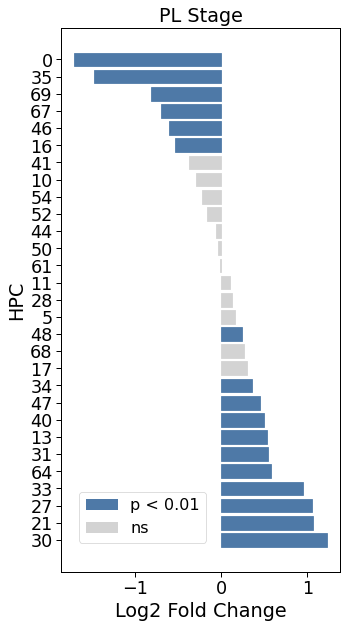

In [87]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(5,10))

nodal_results = enrichment_analysis(df=joint_pleural_df, feature_cols=sorted(list(malignant_clusters)+[10,16]), meta_field='pl_stage', plot_sig_only=False, ax=ax)
ax.set_title('PL Stage')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.55,0.1), fontsize=16)

### Genetics

In [95]:
genetics_subset = genetics[['samples', 'EGFR', 'KRAS', 'TP53']].replace({'negative':0, 'positive':1}).dropna()
genetics_subset

,samples,EGFR,KRAS,TP53
0,ACA_0100,0.0,0.0,0.0
2,ACA_1001,0.0,1.0,0.0
6,ACA_1006,0.0,0.0,1.0
7,ACA_1007,1.0,0.0,0.0
8,ACA_1008,0.0,0.0,0.0
...,...,...,...,...
874,ACA_0995,0.0,0.0,0.0
875,ACA_0996,0.0,0.0,0.0
876,ACA_0997,0.0,0.0,1.0
877,ACA_0998,0.0,0.0,1.0


In [96]:
print(genetics_subset['EGFR'].value_counts()) 
print(genetics_subset['KRAS'].value_counts())
print(genetics_subset['TP53'].value_counts())

0.0    573
1.0     80
Name: EGFR, dtype: int64
0.0    393
1.0    260
Name: KRAS, dtype: int64
0.0    423
1.0    230
Name: TP53, dtype: int64


In [101]:
genetics_rep_df = sample_rep_df.merge(genetics_subset, on='samples', how='inner')

In [102]:
print(genetics_rep_df['EGFR'].value_counts()) 
print(genetics_rep_df['KRAS'].value_counts())
print(genetics_rep_df['TP53'].value_counts())

0.0    558
1.0     80
Name: EGFR, dtype: int64
0.0    382
1.0    256
Name: KRAS, dtype: int64
0.0    413
1.0    225
Name: TP53, dtype: int64


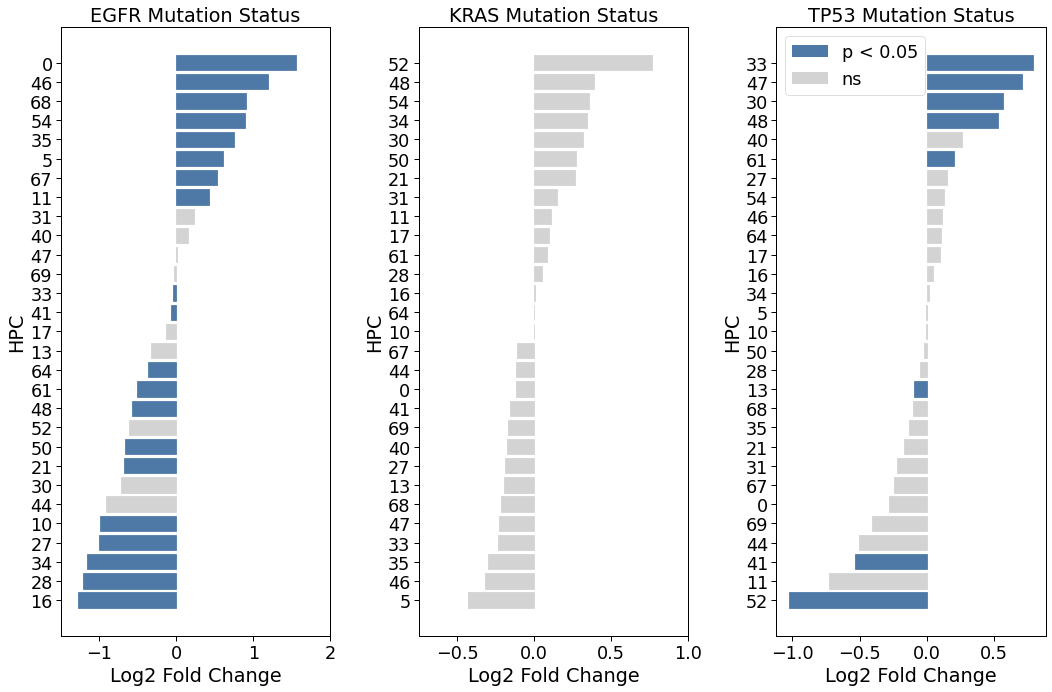

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axs = axs.flatten()

egfr_results = enrichment_analysis(df=genetics_rep_df, feature_cols=sorted(list(malignant_clusters)+[10,16]), meta_field='EGFR', alpha=0.05, plot_sig_only=False, ax=axs[0])
kras_results = enrichment_analysis(df=genetics_rep_df, feature_cols=sorted(list(malignant_clusters)+[10,16]), meta_field='KRAS', alpha=0.05, plot_sig_only=False, ax=axs[1])
tp53_results = enrichment_analysis(df=genetics_rep_df, feature_cols=sorted(list(malignant_clusters)+[10,16]), meta_field='TP53', alpha=0.05, plot_sig_only=False, ax=axs[2])

# ax.set_title('PL Stage')

legend_dict = {'p < 0.05':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)

for ax_ in range(len(axs)):
    axs[ax_].set_xlabel('Log2 Fold Change')
    axs[ax_].set_ylabel('HPC')
    axs[ax_].set_title(axs[ax_].get_title().replace('EGFR', 'EGFR Mutation Status').replace('KRAS', 'KRAS Mutation Status').replace('TP53', 'TP53 Mutation Status'))
    # axs[ax_].set_xlim([-1.5, 1.5])
    # axs[ax_].set_xticks([-1, 0, 1])
    axs[ax_].invert_yaxis()

axs[0].set_xlim([-1.5, 2.0])
axs[1].set_xlim([-0.75, 1])
plt.tight_layout()
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.55,0.1), fontsize=16)

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/HPL-LATTICeA/analysis/clinical-and-survival/clinical/genetics_enrichment.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [104]:
clinpath[clinpath['samples'].isin(genetics_rep_df['samples'])]['2015 WHO Classification'].value_counts()

Acinar adenocarcinoma                      256
Solid adenocarcinoma                       188
Papillary adenocarcinoma                   104
Lepidic adenocarcinoma                      65
Minimally invasive adenocarcinoma (MIA)     13
Micropapillary adenocarcinoma               12
Name: 2015 WHO Classification, dtype: int64

In [109]:
genetics[~genetics['EGFR'].isna()]['WHO_subtype'].value_counts()

APA        257
SPA        192
PPA        104
LPA         67
MIA/AIS     19
MPPA        14
Name: WHO_subtype, dtype: int64

## By supercluster

In [ ]:
from numpy import negative
from scipy import stats

def enrichment_to_dataframe(features, log_fold_change, p_values, adj_p_values=None, p_sig_mask=None):
    df = pd.DataFrame()
    df['hpc'] = features
    df['log_fold_change'] = log_fold_change
    df['p_val'] = p_values
    df['p_adj'] = adj_p_values
    df['alpha_mask'] = p_sig_mask
    return df

def enrichment_analysis(df, feature_cols, meta_field, plot_sig_only, alpha=0.01, ax=None):
    if np.unique(df[meta_field]).shape[0] > 2:
        print(f"Covariate {meta_field} must be binary")
        raise ValueError
    
    covariate_mask = df[meta_field] == 1
    positive = df[covariate_mask][feature_cols].values
    # negative = df[~covariate_mask][feature_cols].values
    negative = df[feature_cols].values # compare to overall mean

    mean_positive = np.mean(positive, axis=0)
    mean_negative = np.mean(negative, axis=0)
    log_fold_change = np.log2(mean_positive / mean_negative)

    statistic, p_vals = stats.mannwhitneyu(positive, negative)
    # sorted_p = p_vals[sorted_indices]
    p_vals_adj = stats.false_discovery_control(p_vals, method='bh')
    p_sig_mask_adj = p_vals_adj < alpha

    # features_int = [int(x) for x in feature_cols]

    results_frame = enrichment_to_dataframe(features=feature_cols, log_fold_change=log_fold_change, p_values=p_vals, adj_p_values=p_vals_adj, p_sig_mask=p_sig_mask_adj)
    plot_enrichment(results_frame=results_frame, meta_field=meta_field, alpha=alpha, plot_sig_only=plot_sig_only, ax=ax)
    
    return results_frame
    # plt.gca().invert_yaxis()

def plot_enrichment(results_frame, meta_field, alpha, plot_sig_only, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    results_frame = results_frame.sort_values(by='log_fold_change', ascending=False)
    results_frame = results_frame[~results_frame['log_fold_change'].isna()]
    if plot_sig_only:
        results_frame = results_frame[results_frame['alpha_mask_unadj'] == True]
    x = np.arange(len(results_frame['log_fold_change']))
    ax.barh(x, results_frame['log_fold_change'].values)
    ax.set_ylabel('HPC')
    ax.set_xlabel('Log Fold Change')
    ax.set_yticks(x, results_frame['hpc'].values)
    ax.set_title(f'{meta_field}')
    if not plot_sig_only:
        for i in x:
            if results_frame['p_adj'].values[i] < alpha:
                ax.get_children()[i].set_color('#4E79A7')
                # ax.get_children()[i].set_color('#E15759') # red
            else:
                ax.get_children()[i].set_color('lightgrey')
                # ax.get_children()[i].set_color('#4E79A7') # blue


In [ ]:
from supercluster_dictionary import assign_supercluster

sample_rep_df_melt = pd.melt(sample_rep_df, id_vars=['samples'], value_vars=malignant_clusters, var_name='cluster', value_name='frequency')
sample_rep_df_melt['cluster'] = sample_rep_df_melt['cluster'].apply(lambda x: f'HPC {x}')
sample_rep_df_melt['supercluster'] = sample_rep_df_melt['cluster'].apply(lambda x: assign_supercluster(x)) 
sample_rep_df_melt = sample_rep_df_melt[sample_rep_df_melt['supercluster'] != 'Unknown']
sample_rep_df_melt.loc[sample_rep_df_melt['cluster'] == 'HPC 13', 'supercluster'] = 'HPC 13'
samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('sum')['frequency'].reset_index()
samples_by_supercluster = samples_by_supercluster.pivot(columns=['supercluster'], index='samples', values='frequency')
samples_by_supercluster = samples_by_supercluster.rename(columns={'HPC 13':'Hot, discohesive (high risk)',
                                                                  'Hot, discohesive':'Hot, discohesive (low risk)'})
samples_by_supercluster

/tmp/ipykernel_2778629/3409503576.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('sum')['frequency'].reset_index()


supercluster,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)"
samples,,,,,
ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981
ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879
ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937
ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825
ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585
...,...,...,...,...,...
ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686
ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412
ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764


In [ ]:
nodal_df = clinpath_mo[clinpath_mo['Nodal status'].isin(['N0', 'N1', 'N2'])][['samples', 'os_event_ind', 'os_event_data', 'Nodal status']]
nodal_df

,samples,os_event_ind,os_event_data,Nodal status
1,ACA_0002,0,18.739726,N0
2,ACA_0003,1,57.304110,N0
3,ACA_0004,1,35.178082,N0
4,ACA_0005,0,61.315068,N0
5,ACA_0006,1,0.558904,N0
...,...,...,...,...
1020,ACA_1108,0,31.791781,N0
1021,ACA_1109,1,20.712329,N0
1022,ACA_1110,1,21.994521,N1
1023,ACA_1112,1,24.427397,N0


In [ ]:
joint_nodal_df = samples_by_supercluster.merge(nodal_df, on='samples', how='inner')
joint_nodal_df['n_stage'] = joint_nodal_df['Nodal status'].apply(lambda x: 0 if x == 'N0' else 1)
joint_nodal_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",os_event_ind,os_event_data,Nodal status,n_stage
0,ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981,0,18.739726,N0,0
1,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1,57.304110,N0,0
2,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,1,35.178082,N0,0
3,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,0,61.315068,N0,0
4,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,1,0.558904,N0,0
...,...,...,...,...,...,...,...,...,...,...
812,ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686,0,31.791781,N0,0
813,ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412,1,20.712329,N0,0
814,ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764,1,21.994521,N1,1
815,ACA_1112,0.166667,0.073141,0.153477,0.110312,0.282974,1,24.427397,N0,0


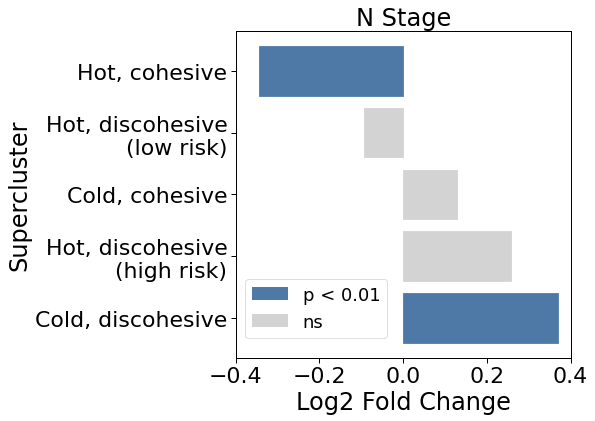

In [ ]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots(figsize=(6,6))
feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']

nodal_results = enrichment_analysis(df=joint_nodal_df, feature_cols=feature_cols, meta_field='n_stage', plot_sig_only=False, ax=ax)
ax.set_title('N Stage')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Supercluster')
ax.set_xlim([-0.4,0.4])
ax.set_yticklabels(['Hot, cohesive', 'Hot, discohesive\n(low risk)', 'Cold, cohesive', 'Hot, discohesive\n(high risk)', 'Cold, discohesive'][::-1])
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.48,0.15), fontsize=18)

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/clinical_associations/N_stage_supercluster.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
nodal_results

,hpc,log_fold_change,p_val,p_adj,alpha_mask
0,"Cold, cohesive",0.128394,4.629935e-02,0.057874,False
1,"Cold, discohesive",0.370648,7.853179e-07,0.000004,True
2,"Hot, discohesive (high risk)",0.257456,2.543095e-02,0.042385,False
3,"Hot, cohesive",-0.344752,7.834804e-06,0.000020,True
4,"Hot, discohesive (low risk)",-0.093701,1.110222e-01,0.111022,False


### PL Stage

In [ ]:
pleural_df = clinpath_mo[clinpath_mo['Pleural Involvement'].isin(['PL0', 'PL1', 'PL2', 'PL3'])][['samples', 'os_event_ind', 'os_event_data', 'Pleural Involvement']]
pleural_df

,samples,os_event_ind,os_event_data,Pleural Involvement
0,ACA_0001,1,83.079452,PL1
1,ACA_0002,0,18.739726,PL0
2,ACA_0003,1,57.304110,PL1
3,ACA_0004,1,35.178082,PL0
4,ACA_0005,0,61.315068,PL0
...,...,...,...,...
1020,ACA_1108,0,31.791781,PL0
1021,ACA_1109,1,20.712329,PL2
1022,ACA_1110,1,21.994521,PL0
1023,ACA_1112,1,24.427397,PL0


In [ ]:
joint_pleural_df = samples_by_supercluster.merge(pleural_df, on='samples', how='inner')
joint_pleural_df['pl_stage'] = joint_pleural_df['Pleural Involvement'].apply(lambda x: 0 if x == 'PL0' else 1)
joint_pleural_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",os_event_ind,os_event_data,Pleural Involvement,pl_stage
0,ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981,0,18.739726,PL0,0
1,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1,57.304110,PL1,1
2,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,1,35.178082,PL0,0
3,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,0,61.315068,PL0,0
4,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,1,0.558904,PL2,1
...,...,...,...,...,...,...,...,...,...,...
871,ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686,0,31.791781,PL0,0
872,ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412,1,20.712329,PL2,1
873,ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764,1,21.994521,PL0,0
874,ACA_1112,0.166667,0.073141,0.153477,0.110312,0.282974,1,24.427397,PL0,0


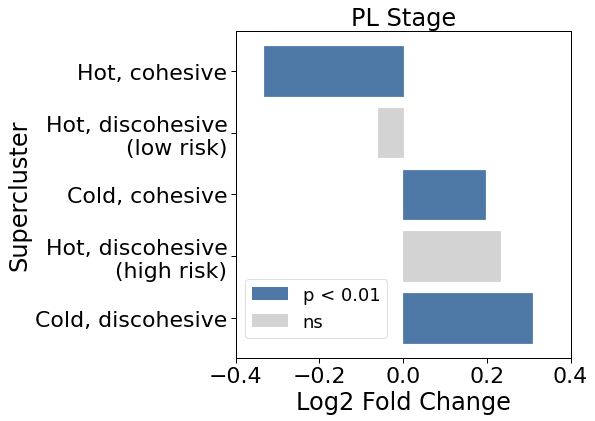

In [ ]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots(figsize=(6,6))
feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']

nodal_results = enrichment_analysis(df=joint_pleural_df, feature_cols=feature_cols, meta_field='pl_stage', plot_sig_only=False, ax=ax)
ax.set_title('PL Stage')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Supercluster')
ax.set_yticklabels(['Hot, cohesive', 'Hot, discohesive\n(low risk)', 'Cold, cohesive', 'Hot, discohesive\n(high risk)', 'Cold, discohesive'][::-1], rotation=0)
ax.set_xlim([-0.4,0.4])
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.48,0.15), fontsize=18)

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/clinical_associations/PL_stage_supercluster.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
nodal_results

,hpc,log_fold_change,p_val,p_adj,alpha_mask
0,"Cold, cohesive",0.194614,0.000462,0.000770,True
1,"Cold, discohesive",0.308322,0.000004,0.000010,True
2,"Hot, discohesive (high risk)",0.231417,0.024095,0.030118,False
3,"Hot, cohesive",-0.332247,0.000004,0.000010,True
4,"Hot, discohesive (low risk)",-0.059414,0.299472,0.299472,False


### Sex

In [ ]:
sex_df = clinpath_mo[~clinpath_mo['male'].isna()][['samples', 'os_event_ind', 'os_event_data', 'male']]
sex_df

,samples,os_event_ind,os_event_data,male
0,ACA_0001,1,83.079452,1
1,ACA_0002,0,18.739726,0
2,ACA_0003,1,57.304110,1
3,ACA_0004,1,35.178082,0
4,ACA_0005,0,61.315068,0
...,...,...,...,...
1020,ACA_1108,0,31.791781,0
1021,ACA_1109,1,20.712329,1
1022,ACA_1110,1,21.994521,0
1023,ACA_1112,1,24.427397,1


In [ ]:
joint_sex_df = samples_by_supercluster.merge(sex_df, on='samples', how='inner')
joint_sex_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",os_event_ind,os_event_data,male
0,ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981,0,18.739726,0
1,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1,57.304110,1
2,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,1,35.178082,0
3,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,0,61.315068,0
4,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,1,0.558904,0
...,...,...,...,...,...,...,...,...,...
910,ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686,0,31.791781,0
911,ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412,1,20.712329,1
912,ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764,1,21.994521,0
913,ACA_1112,0.166667,0.073141,0.153477,0.110312,0.282974,1,24.427397,1


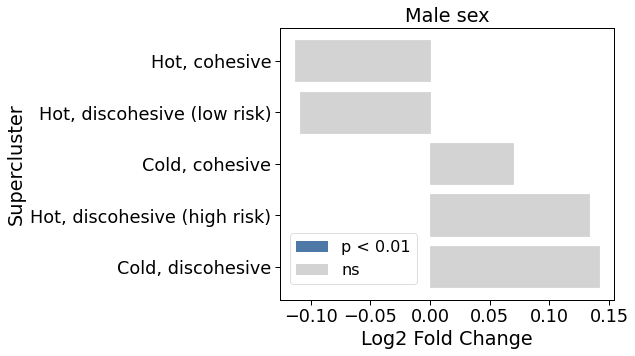

In [ ]:
sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(6,5))
feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']

nodal_results = enrichment_analysis(df=joint_sex_df, feature_cols=feature_cols, meta_field='male', plot_sig_only=False, ax=ax)
ax.set_title('Male sex')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Supercluster')
sns.move_legend(ax, loc='right', bbox_to_anchor=(0.435,0.15), fontsize=16)

### PD-L1

In [ ]:
clinpath_mo['PD-L1 Stained Percentage'].value_counts()

0%         622
1-49%       97
50-100%     84
Name: PD-L1 Stained Percentage, dtype: int64

In [ ]:
pdl1_df = clinpath_mo[clinpath_mo['PD-L1 Stained Percentage'].isin(['0%', '1-49%', '50-100%'])][['samples', 'os_event_ind', 'os_event_data', 'PD-L1 Stained Percentage']]
pdl1_df = pdl1_df.rename(columns={'PD-L1 Stained Percentage':'pdl1_status'})
pdl1_df['pdl1_status'] = pdl1_df['pdl1_status'].replace({'0%':0,
                                                         '1-49%':1,
                                                         '50-100%':1})
pdl1_df

,samples,os_event_ind,os_event_data,pdl1_status
0,ACA_0001,1,83.079452,1
2,ACA_0003,1,57.304110,0
3,ACA_0004,1,35.178082,0
4,ACA_0005,0,61.315068,0
5,ACA_0006,1,0.558904,0
...,...,...,...,...
1020,ACA_1108,0,31.791781,0
1021,ACA_1109,1,20.712329,0
1022,ACA_1110,1,21.994521,1
1023,ACA_1112,1,24.427397,0


In [ ]:
joint_pdl1_df = samples_by_supercluster.merge(pdl1_df, on='samples', how='inner')
joint_pdl1_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",os_event_ind,os_event_data,pdl1_status
0,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1,57.304110,0
1,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,1,35.178082,0
2,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,0,61.315068,0
3,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,1,0.558904,0
4,ACA_0008,0.263833,0.249800,0.002005,0.119086,0.219727,1,14.268493,0
...,...,...,...,...,...,...,...,...,...
720,ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686,0,31.791781,0
721,ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412,1,20.712329,0
722,ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764,1,21.994521,1
723,ACA_1112,0.166667,0.073141,0.153477,0.110312,0.282974,1,24.427397,0


In [ ]:
joint_pdl1_df['pdl1_status'].value_counts()

0    549
1    176
Name: pdl1_status, dtype: int64

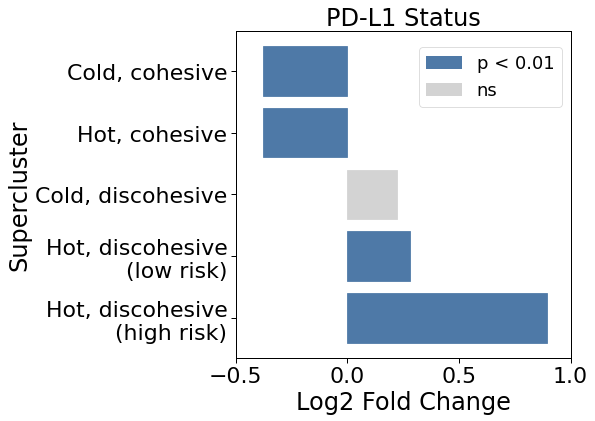

In [ ]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots(figsize=(6,6))
feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']

pdl1_results = enrichment_analysis(df=joint_pdl1_df, feature_cols=feature_cols, meta_field='pdl1_status', plot_sig_only=False, ax=ax)
ax.set_title('PD-L1 Status')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Supercluster')
ax.set_xlim([-0.5,1])
ax.set_xticks(list(np.arange(-0.5, 1.5, 0.5)))
ax.set_yticklabels(['Cold, cohesive', 'Hot, cohesive', 'Cold, discohesive', 'Hot, discohesive\n(low risk)', 'Hot, discohesive\n(high risk)'][::-1], rotation=0)

sns.move_legend(ax, loc='right', bbox_to_anchor=(1,0.86), fontsize=18)

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/clinical_associations/PDL1_supercluster.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
pdl1_results

,hpc,log_fold_change,p_val,p_adj,alpha_mask
0,"Cold, cohesive",-0.379371,2.807379e-03,3.509224e-03,True
1,"Cold, discohesive",0.223028,3.054740e-02,3.054740e-02,False
2,"Hot, discohesive (high risk)",0.895126,4.572574e-10,2.286287e-09,True
3,"Hot, cohesive",-0.377307,2.375134e-04,3.958557e-04,True
4,"Hot, discohesive (low risk)",0.278683,6.914586e-05,1.728647e-04,True


In [ ]:
joint_pdl1_df.columns

Index(['samples', 'Cold, cohesive', 'Cold, discohesive',
       'Hot, discohesive (high risk)', 'Hot, cohesive',
       'Hot, discohesive (low risk)', 'os_event_ind', 'os_event_data',
       'pdl1_status'],
      dtype='object')

### Smoking

In [ ]:
genetics = pd.read_csv('/mnt/cephfs/home/users/krakovic/sharedscratch/datasets/LATTICeA/LatticeDatabase_withgenetics.tsv', sep='\t')
genetics = genetics.sort_values(by='case_num').reset_index()
genetics['case_num'] = genetics['case_num'].astype(str)

samples_list = []
for i in range(1, 5):
    indexes = genetics[genetics['case_num'].str.len() == i].index
    if i == 1:
        samples_list.extend(['ACA_000' + str(x) for x in genetics.iloc[indexes]['case_num']])
    elif i == 2:
        samples_list.extend(['ACA_00' + str(x) for x in genetics.iloc[indexes]['case_num']])
    elif i == 3:
        samples_list.extend(['ACA_0' + str(x) for x in genetics.iloc[indexes]['case_num']])
    else:
        samples_list.extend(['ACA_' + str(x) for x in genetics.iloc[indexes]['case_num']])

genetics['samples'] = samples_list
genetics = genetics.replace({'negative':0, 'positive':1})
genetics

,index,case_num,OS_time,OS_status,CSS_time,CSS_status,RFS_time,RFS_status,chemo_status,age,...,KIT,NRAS,MAP2K1,FBXW7,SMARCA4,HRAS,PDGFRA,suppressor,driver,samples
0,159,2,570,0,570.00,0,520.00,0,no,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,none,ACA_0002
1,238,3,1743,1,1095.75,0,210.00,0,no,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53,EGFR,ACA_0003
2,319,4,1070,1,1070.00,1,1070.00,1,no,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,none,ACA_0004
3,406,5,1865,0,1095.75,0,1095.75,0,no,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,none,ACA_0005
4,499,6,17,1,17.00,0,17.00,0,no,81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACA_0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,101,1108,967,0,967.00,0,967.00,0,no,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,EGFR,ACA_1108
875,102,1109,630,1,630.00,0,475.00,1,no,83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,none,none,ACA_1109
876,103,1110,669,1,669.00,0,560.00,1,yes,71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53,KRAS,ACA_1110
877,104,1112,743,1,743.00,0,711.00,0,no,65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53,other,ACA_1112


In [ ]:
genetics['over_65'] = genetics['age'].apply(lambda x: 1 if x > 65 else 0)
genetics['smoked_over_0_packyears'] = survival['pack_years'].apply(lambda x: 1 if x > 0 else 0)
genetics['smoked_over_5_packyears'] = survival['pack_years'].apply(lambda x: 1 if x > 5 else 0)
genetics['smoked_over_35_packyears'] = survival['pack_years'].apply(lambda x: 1 if x > 35 else 0)
genetics['smoked_over_40_packyears'] = survival['pack_years'].apply(lambda x: 1 if x > 40 else 0)

In [ ]:
joint_smoking_df = samples_by_supercluster.merge(genetics[['samples', 'smoked_over_0_packyears', 'smoked_over_5_packyears', 'smoked_over_35_packyears', 'smoked_over_40_packyears']].dropna(), on='samples', how='inner')
joint_smoking_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",smoked_over_0_packyears,smoked_over_5_packyears,smoked_over_35_packyears,smoked_over_40_packyears
0,ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981,1.0,1.0,1.0,0.0
1,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1.0,1.0,0.0,0.0
2,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,1.0,1.0,0.0,0.0
3,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,1.0,1.0,0.0,0.0
4,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
781,ACA_1019,0.280824,0.051345,0.019211,0.260566,0.224240,1.0,1.0,1.0,1.0
782,ACA_1020,0.058824,0.486631,0.026738,0.139037,0.171791,1.0,1.0,0.0,0.0
783,ACA_1021,0.445189,0.207755,0.001915,0.182384,0.061273,1.0,1.0,0.0,0.0
784,ACA_1022,0.474170,0.124231,0.000308,0.112854,0.206950,1.0,1.0,1.0,1.0


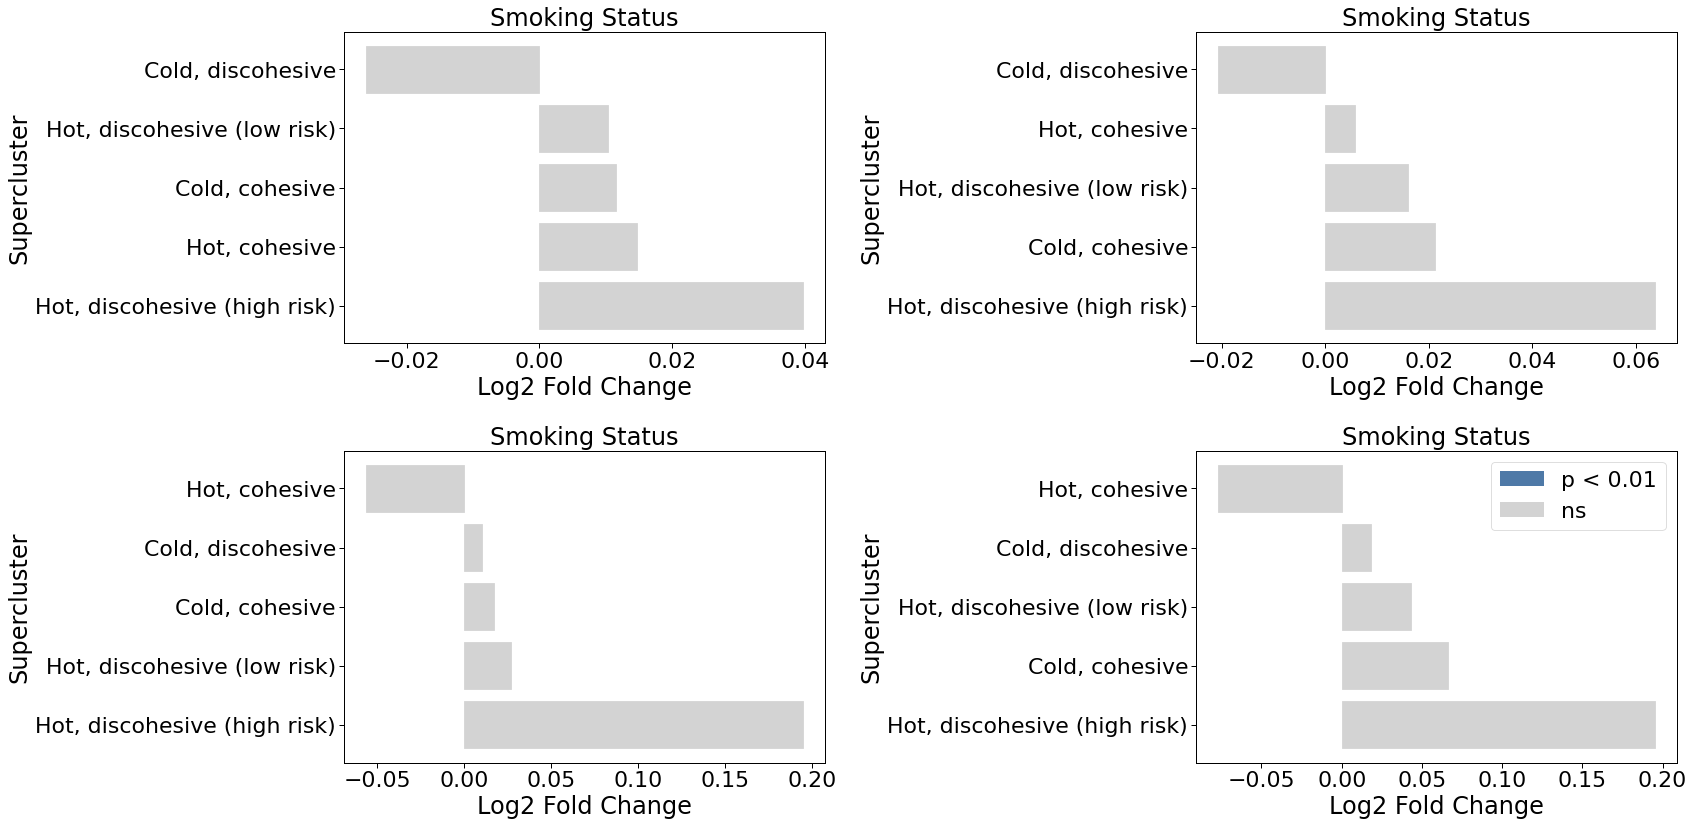

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24,12))
axs = axs.flatten()

for i, duration in enumerate(['smoked_over_0_packyears', 'smoked_over_5_packyears', 'smoked_over_35_packyears', 'smoked_over_40_packyears']):
    feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']
    smoking_results = enrichment_analysis(df=joint_smoking_df, feature_cols=feature_cols, meta_field=duration, plot_sig_only=False, ax=axs[i])
    axs[i].set_title('Smoking Status')
    legend_dict = {'p < 0.01':'#4E79A7',
                   'ns':'lightgrey'}
    legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]
    plt.legend(handles=legend_elements)
    axs[i].set_xlabel('Log2 Fold Change')
    axs[i].set_ylabel('Supercluster')
    # ax.set_yticklabels(['Cold, cohesive', 'Hot, cohesive', 'Cold, discohesive', 'Hot, discohesive\n(low risk)', 'Hot, discohesive\n(high risk)'][::-1], rotation=0)
    # sns.move_legend(axs[i], loc='right', bbox_to_anchor=(1,0.86), fontsize=18)

plt.tight_layout()

### Age

In [ ]:
genetics['over_65'].value_counts()

1    541
0    338
Name: over_65, dtype: int64

In [ ]:
joint_age_df = samples_by_supercluster.merge(genetics[['samples', 'over_65']].dropna(), on='samples', how='inner')
joint_age_df

,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",over_65
0,ACA_0002,0.148699,0.362454,0.016729,0.247212,0.144981,1
1,ACA_0003,0.321199,0.114918,0.009993,0.137045,0.169879,1
2,ACA_0004,0.381119,0.066434,0.066434,0.115385,0.062937,0
3,ACA_0005,0.017937,0.058296,0.000000,0.650224,0.192825,0
4,ACA_0006,0.306132,0.141509,0.136792,0.166981,0.123585,1
...,...,...,...,...,...,...,...
856,ACA_1108,0.053922,0.093137,0.004902,0.573529,0.215686,0
857,ACA_1109,0.212647,0.242941,0.272059,0.093235,0.119412,1
858,ACA_1110,0.080092,0.124714,0.021739,0.225400,0.418764,1
859,ACA_1112,0.166667,0.073141,0.153477,0.110312,0.282974,0


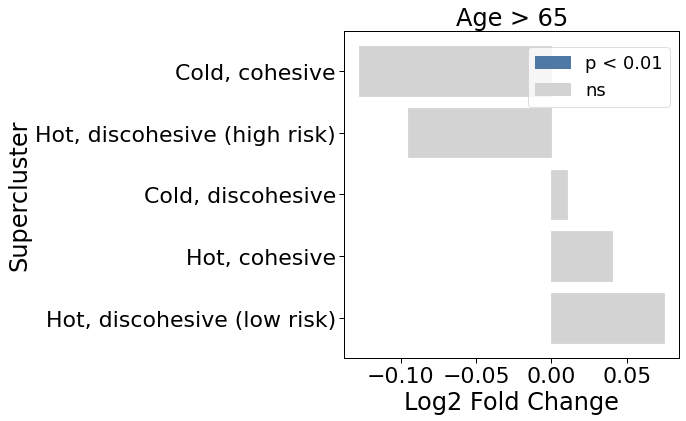

In [ ]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots(figsize=(6,6))
feature_cols = ['Cold, cohesive', 'Cold, discohesive', 'Hot, discohesive (high risk)', 'Hot, cohesive', 'Hot, discohesive (low risk)']

age_results = enrichment_analysis(df=joint_age_df, feature_cols=feature_cols, meta_field='over_65', plot_sig_only=False, ax=ax)
ax.set_title('Age > 65')

legend_dict = {'p < 0.01':'#4E79A7',
               'ns':'lightgrey'}

legend_elements = [Patch(facecolor=color, label=group) for group, color in legend_dict.items()]

plt.legend(handles=legend_elements)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Supercluster')
# ax.set_yticklabels(['Cold, cohesive', 'Hot, cohesive', 'Cold, discohesive', 'Hot, discohesive\n(low risk)', 'Hot, discohesive\n(high risk)'][::-1], rotation=0)

sns.move_legend(ax, loc='right', bbox_to_anchor=(1,0.86), fontsize=18)

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/clinical_associations/PDL1_supercluster.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

### Patient UMAP

In [44]:
import umap

In [45]:
sample_rep_df

,0,5,10,11,13,16,17,21,27,28,...,48,50,52,54,61,64,67,68,69,samples
0,0.003670,0.000459,0.019725,0.050459,0.002294,0.177982,0.015138,0.000459,0.000000,0.059174,...,0.037156,0.104587,0.001376,0.067431,0.008716,0.004128,0.150000,0.016055,0.124771,ACA_0193
2,0.287338,0.003247,0.006494,0.000000,0.016234,0.095779,0.006494,0.000000,0.011364,0.000000,...,0.000000,0.004870,0.001623,0.000000,0.024351,0.021104,0.047078,0.047078,0.081169,ACA_0476
3,0.000000,0.014812,0.110876,0.000000,0.022006,0.031739,0.276344,0.008887,0.003386,0.044858,...,0.089716,0.039357,0.000000,0.001270,0.120186,0.081253,0.000000,0.000423,0.006348,ACA_0837
4,0.036900,0.000000,0.221402,0.000000,0.003690,0.420664,0.029520,0.000000,0.000000,0.059041,...,0.000000,0.003690,0.003690,0.003690,0.073801,0.000000,0.088561,0.000000,0.025830,ACA_0574
5,0.000764,0.015533,0.003820,0.270435,0.016552,0.007639,0.002037,0.018844,0.015788,0.001019,...,0.028011,0.114082,0.028266,0.091418,0.006621,0.092692,0.001273,0.042271,0.014260,ACA_0484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.108108,0.015444,0.029923,0.000000,0.045367,0.084942,0.051158,0.006757,0.016409,0.030888,...,0.022201,0.069498,0.000000,0.002896,0.051158,0.133205,0.070463,0.047297,0.036680,ACA_0412
1003,0.005226,0.000000,0.088850,0.000000,0.111498,0.121951,0.010453,0.000000,0.019164,0.071429,...,0.033101,0.024390,0.000000,0.000000,0.113240,0.029617,0.001742,0.000000,0.020906,ACA_0626
1004,0.000740,0.001036,0.000000,0.148208,0.001036,0.000296,0.001184,0.001777,0.001629,0.000000,...,0.000000,0.019840,0.024282,0.371039,0.000000,0.001629,0.004886,0.004442,0.002221,ACA_0656
1005,0.029304,0.007326,0.000000,0.000000,0.032967,0.029304,0.065934,0.003663,0.000000,0.025641,...,0.032967,0.234432,0.000000,0.010989,0.058608,0.003663,0.087912,0.003663,0.032967,ACA_0406


In [46]:
sample_rep_df_melt = pd.melt(sample_rep_df, id_vars=['samples'], value_vars=malignant_clusters, var_name='cluster', value_name='frequency')
sample_rep_df_melt['cluster'] = sample_rep_df_melt['cluster'].apply(lambda x: f'HPC {x}')
sample_rep_df_melt['supercluster'] = sample_rep_df_melt['cluster'].apply(lambda x: assign_supercluster(x)) 
sample_rep_df_melt = sample_rep_df_melt[sample_rep_df_melt['supercluster'] != 'Unknown']
sample_rep_df_melt.loc[sample_rep_df_melt['cluster'] == 'HPC 13', 'supercluster'] = 'HPC 13'
samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('mean')['frequency'].reset_index()
samples_by_supercluster = samples_by_supercluster.pivot(columns=['supercluster'], index='samples', values='frequency')
samples_by_supercluster = samples_by_supercluster.rename(columns={'HPC 13':'Hot, discohesive (high risk)',
                                                                  'Hot, discohesive':'Hot, discohesive (low risk)'})
samples_by_supercluster

/tmp/ipykernel_2290626/1008025296.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  samples_by_supercluster = sample_rep_df_melt.groupby(['samples', 'supercluster']).agg('mean')['frequency'].reset_index()


supercluster,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)"
samples,,,,,
ACA_0002,0.021243,0.090613,0.016729,0.049442,0.024164
ACA_0003,0.045886,0.028729,0.009993,0.027409,0.028313
ACA_0004,0.054446,0.016608,0.066434,0.023077,0.010490
ACA_0005,0.002562,0.014574,0.000000,0.130045,0.032138
ACA_0006,0.043733,0.035377,0.136792,0.033396,0.020597
...,...,...,...,...,...
ACA_1108,0.007703,0.023284,0.004902,0.114706,0.035948
ACA_1109,0.030378,0.060735,0.272059,0.018647,0.019902
ACA_1110,0.011442,0.031178,0.021739,0.045080,0.069794


In [47]:
reducer = umap.UMAP()

malignant_umap = reducer.fit_transform(sample_rep_df.iloc[:, :-1])

In [48]:
malignant_umap = pd.DataFrame(malignant_umap, columns=['UMAP1', 'UMAP2'])
malignant_umap['samples'] = sample_rep_df['samples'].values
malignant_umap

,UMAP1,UMAP2,samples
0,5.181973,5.081076,ACA_0193
1,2.532690,4.166887,ACA_0476
2,7.798686,8.458660,ACA_0837
3,4.908518,6.622509,ACA_0574
4,7.064612,0.889942,ACA_0484
...,...,...,...
910,5.203236,4.262067,ACA_0412
911,6.908819,6.719794,ACA_0626
912,5.305185,1.604928,ACA_0656
913,7.681726,6.529031,ACA_0406


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

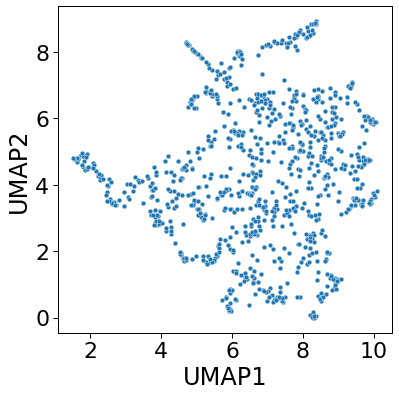

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(malignant_umap, x='UMAP1', y='UMAP2', ax=ax)

In [50]:
malignant_umap_joint = malignant_umap.merge(clinpath_mo[['2015 WHO Classification', 'samples']], on='samples')
malignant_umap_joint

,UMAP1,UMAP2,samples,2015 WHO Classification
0,5.181973,5.081076,ACA_0193,Acinar adenocarcinoma
1,2.532690,4.166887,ACA_0476,Minimally invasive adenocarcinoma (MIA)
2,7.798686,8.458660,ACA_0837,Solid adenocarcinoma
3,4.908518,6.622509,ACA_0574,Solid adenocarcinoma
4,7.064612,0.889942,ACA_0484,Papillary adenocarcinoma
...,...,...,...,...
910,5.203236,4.262067,ACA_0412,Acinar adenocarcinoma
911,6.908819,6.719794,ACA_0626,Solid adenocarcinoma
912,5.305185,1.604928,ACA_0656,Papillary adenocarcinoma
913,7.681726,6.529031,ACA_0406,Solid adenocarcinoma


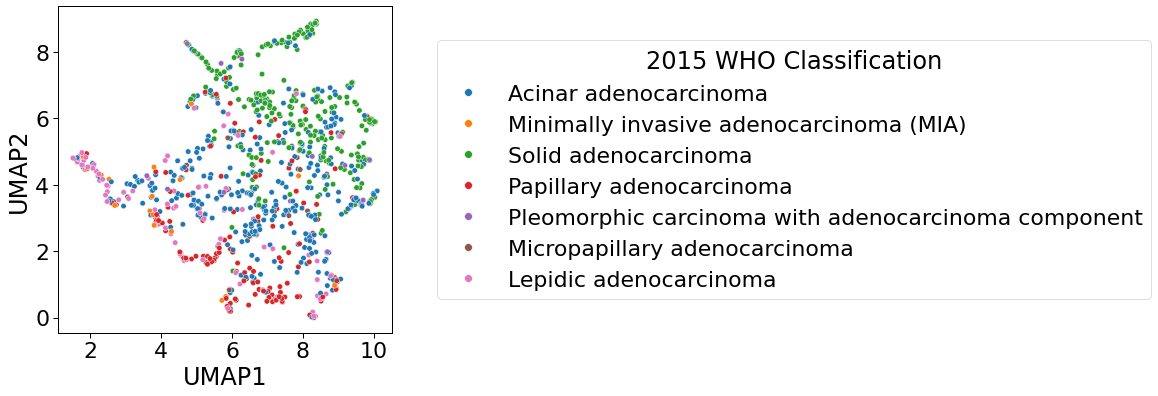

In [51]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(malignant_umap_joint, x='UMAP1', y='UMAP2', hue='2015 WHO Classification', s=30, ax=ax)
sns.move_legend(ax, loc='right', bbox_to_anchor=(3.3,0.5), markerscale=1.4)

In [52]:
samples_by_supercluster['predom_supercluster'] = samples_by_supercluster.idxmax(axis=1)
samples_by_supercluster['predom_supercluster'].value_counts()

Hot, cohesive                   282
Cold, discohesive               245
Cold, cohesive                  149
Hot, discohesive (low risk)     132
Hot, discohesive (high risk)    107
Name: predom_supercluster, dtype: int64

In [53]:
samples_by_supercluster.reset_index()

supercluster,samples,"Cold, cohesive","Cold, discohesive","Hot, discohesive (high risk)","Hot, cohesive","Hot, discohesive (low risk)",predom_supercluster
0,ACA_0002,0.021243,0.090613,0.016729,0.049442,0.024164,"Cold, discohesive"
1,ACA_0003,0.045886,0.028729,0.009993,0.027409,0.028313,"Cold, cohesive"
2,ACA_0004,0.054446,0.016608,0.066434,0.023077,0.010490,"Hot, discohesive (high risk)"
3,ACA_0005,0.002562,0.014574,0.000000,0.130045,0.032138,"Hot, cohesive"
4,ACA_0006,0.043733,0.035377,0.136792,0.033396,0.020597,"Hot, discohesive (high risk)"
...,...,...,...,...,...,...,...
910,ACA_1108,0.007703,0.023284,0.004902,0.114706,0.035948,"Hot, cohesive"
911,ACA_1109,0.030378,0.060735,0.272059,0.018647,0.019902,"Hot, discohesive (high risk)"
912,ACA_1110,0.011442,0.031178,0.021739,0.045080,0.069794,"Hot, discohesive (low risk)"
913,ACA_1112,0.023810,0.018285,0.153477,0.022062,0.047162,"Hot, discohesive (high risk)"


,UMAP1,UMAP2,samples,predom_supercluster
0,5.181973,5.081076,ACA_0193,"Hot, cohesive"
1,2.532690,4.166887,ACA_0476,"Hot, cohesive"
2,7.798686,8.458660,ACA_0837,"Cold, cohesive"
3,4.908518,6.622509,ACA_0574,"Hot, cohesive"
4,7.064612,0.889942,ACA_0484,"Cold, cohesive"
...,...,...,...,...
910,5.203236,4.262067,ACA_0412,"Cold, discohesive"
911,6.908819,6.719794,ACA_0626,"Hot, discohesive (high risk)"
912,5.305185,1.604928,ACA_0656,"Cold, cohesive"
913,7.681726,6.529031,ACA_0406,"Hot, cohesive"


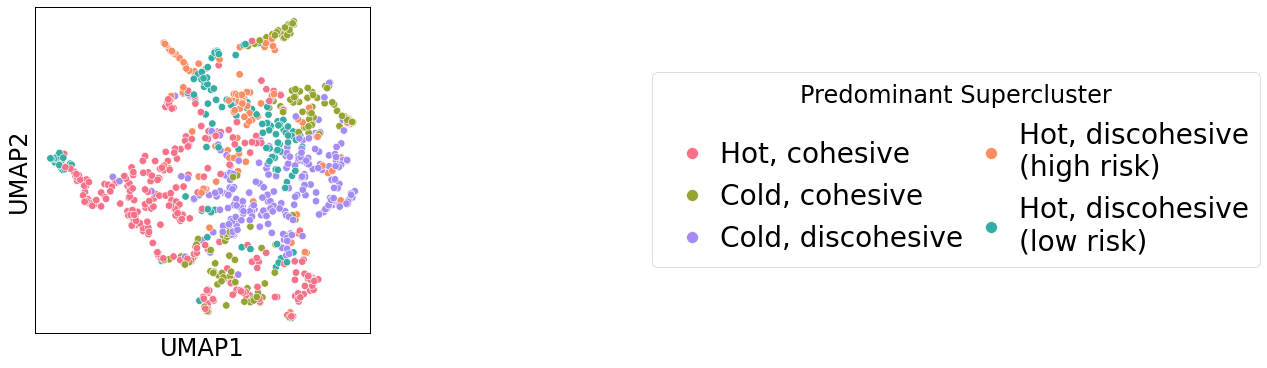

In [68]:
malignant_umap_joint = malignant_umap.merge(samples_by_supercluster[['predom_supercluster']].reset_index(), on='samples')
malignant_umap_joint = malignant_umap_joint.replace({'Hot, discohesive (high risk)':'Hot, discohesive\n(high risk)',
                                                     'Hot, discohesive (low risk)':'Hot, discohesive\n(low risk)'})

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(malignant_umap_joint, x='UMAP1', y='UMAP2', hue='predom_supercluster', palette={'Hot, cohesive':(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
                         'Hot, discohesive\n(low risk)':(0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
                         'Cold, cohesive':(0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
                         'Cold, discohesive':(0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
                         'Hot, discohesive\n(high risk)':(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)}, 
                         s=55, ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.move_legend(ax, loc='right', bbox_to_anchor=(3.7,0.5), title='Predominant Supercluster', ncol=2, markerscale=1.6, fontsize=28, columnspacing=0., handletextpad=0.)

plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/clinical_associations/UMAP_patient_level_by_supercluster.pdf', 
            dpi=300, bbox_inches='tight', pad_inches=0.1)
